In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import re
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [4]:
torch.__version__

'2.4.0'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
with open ("/kaggle/input/gdwawd/temp.txt",'r') as data:
    text = data.read()


In [8]:
text[:20]

'\ufeff"Well, Prince, so G'

In [9]:
def preprocess_text(text):
    text = re.sub('\n', '.', text)
    text = re.sub('[^a-zA-Z0-9 /.]', '', text)

    text = text.lower()
    sentences = text.split('.')
    word_sequences = [sentence.strip().split() for sentence in sentences if sentence.strip()]
    return word_sequences

In [10]:
p_text = preprocess_text(str(text))
p_text[:5]

[['well',
  'prince',
  'so',
  'genoa',
  'and',
  'lucca',
  'are',
  'now',
  'just',
  'family',
  'estates',
  'of',
  'the'],
 ['buonapartes'],
 ['but',
  'i',
  'warn',
  'you',
  'if',
  'you',
  'dont',
  'tell',
  'me',
  'that',
  'this',
  'means',
  'war'],
 ['if',
  'you',
  'still',
  'try',
  'to',
  'defend',
  'the',
  'infamies',
  'and',
  'horrors',
  'perpetrated',
  'by',
  'that'],
 ['antichristi',
  'really',
  'believe',
  'he',
  'is',
  'antichristi',
  'will',
  'have',
  'nothing',
  'more']]

In [11]:
len(p_text)

66108

In [12]:
# build the vocabulary of characters and mappings to/from integers
comb = []
for sentence in p_text:
    comb += sentence
chars = sorted(list(set(comb)))
print(chars[:10])

['1', '10', '100', '10000', '100000', '102', '10annette', '11', '110', '120']


In [13]:
len(chars)

20067

In [14]:
from collections import Counter

# Build a vocabulary from all words
all_words = [word for sentence in p_text for word in sentence]
word_counts = Counter(all_words)
vocab = sorted(word_counts)  # List of unique words in alphabetical order
vocab_size = len(vocab)

# Word-to-index and index-to-word mappings
word_to_index = {word: idx for idx, word in enumerate(vocab)}
word_to_index["."] = 0
index_to_word = {idx: word for word, idx in word_to_index.items()}


In [15]:
# pprint(index_to_word)
for i in range(10):
    print(i, index_to_word[i])

0 .
1 10
2 100
3 10000
4 100000
5 102
6 10annette
7 11
8 110
9 120


In [16]:
def create_word_pairs(sequences, context_length):
    inputs = []
    outputs = []

    for sentence in sequences:
        context = ["."] * context_length
        for word in sentence + ["."]:
            inputs.append([word_to_index[i] for i in context])
            outputs.append(word_to_index[word])
            print(f"{' '.join(context)} ----> {word}")
            context.pop(0)
            context.append(word)
        print()

#     X = torch.tensor(inputs).to(device)
#     Y = torch.tensor(outputs).to(device)
    return inputs,outputs
# inputs, outputs

In [17]:
context_length = 4

# inputs, outputs = create_word_pairs(p_text[:10], context_length)
inputs, outputs = create_word_pairs(p_text[:10], context_length)

. . . . ----> well
. . . well ----> prince
. . well prince ----> so
. well prince so ----> genoa
well prince so genoa ----> and
prince so genoa and ----> lucca
so genoa and lucca ----> are
genoa and lucca are ----> now
and lucca are now ----> just
lucca are now just ----> family
are now just family ----> estates
now just family estates ----> of
just family estates of ----> the
family estates of the ----> .

. . . . ----> buonapartes
. . . buonapartes ----> .

. . . . ----> but
. . . but ----> i
. . but i ----> warn
. but i warn ----> you
but i warn you ----> if
i warn you if ----> you
warn you if you ----> dont
you if you dont ----> tell
if you dont tell ----> me
you dont tell me ----> that
dont tell me that ----> this
tell me that this ----> means
me that this means ----> war
that this means war ----> .

. . . . ----> if
. . . if ----> you
. . if you ----> still
. if you still ----> try
if you still try ----> to
you still try to ----> defend
still try to defend ----> the
try to defend

In [18]:
inputs[:10],outputs[:10]
# visualization

([[0, 0, 0, 0],
  [0, 0, 0, 19474],
  [0, 0, 19474, 13577],
  [0, 19474, 13577, 16346],
  [19474, 13577, 16346, 7492],
  [13577, 16346, 7492, 722],
  [16346, 7492, 722, 10581],
  [7492, 722, 10581, 993],
  [722, 10581, 993, 11956],
  [10581, 993, 11956, 9719]],
 [19474, 13577, 16346, 7492, 722, 10581, 993, 11956, 9719, 6498])

In [19]:
# # Assume you already have a vocabulary built
# vocab = sorted(set(word for sentence in p_text for word in sentence))
# vocab_size = len(vocab)

# # Create word-to-index and index-to-word mappings
# word_to_index = {word: idx for idx, word in enumerate(vocab)}
# index_to_word = {idx: word for word, idx in word_to_index.items()}

# # Convert inputs and outputs to indices
# X = [[word_to_index[word] for word in context] for context in inputs]
# y = [word_to_index[word] for word in outputs]


In [20]:
p_text[10]

['with']

In [21]:

# Convert inputs and outputs to numerical format (using word indices)
# X = [[word_to_index[word] for word in input_seq] for input_seq in inputs]
# y = [word_to_index[output_word] for output_word in outputs]


In [22]:
# X[:10], y[:10]

In [23]:
X = torch.tensor(inputs).to(device)
Y = torch.tensor(outputs).to(device)

In [24]:
X[:10], Y[:10]

(tensor([[    0,     0,     0,     0],
         [    0,     0,     0, 19474],
         [    0,     0, 19474, 13577],
         [    0, 19474, 13577, 16346],
         [19474, 13577, 16346,  7492],
         [13577, 16346,  7492,   722],
         [16346,  7492,   722, 10581],
         [ 7492,   722, 10581,   993],
         [  722, 10581,   993, 11956],
         [10581,   993, 11956,  9719]], device='cuda:0'),
 tensor([19474, 13577, 16346,  7492,   722, 10581,   993, 11956,  9719,  6498],
        device='cuda:0'))

In [25]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([122, 4]), torch.int64, torch.Size([122]), torch.int64)

In [26]:
emb_dim = 20
emb = torch.nn.Embedding(len(word_to_index), emb_dim)

In [27]:
emb.weight

Parameter containing:
tensor([[ 0.4478, -0.1311, -1.3305,  ...,  1.0859,  0.0935,  0.2067],
        [ 0.0629,  0.5540, -0.4717,  ..., -0.2561,  0.1273, -1.8692],
        [ 0.7682, -0.0779, -1.6138,  ..., -0.8021,  0.7011, -0.9538],
        ...,
        [-0.3968,  0.1338, -0.5877,  ...,  1.9415,  0.6181,  0.4516],
        [ 0.9917, -0.4532,  0.5355,  ..., -1.2548,  0.5065,  1.2992],
        [-0.2803,  1.1558, -0.8446,  ..., -1.2084, -1.1837, -0.8057]],
       requires_grad=True)

In [28]:
emb.weight.shape

torch.Size([20068, 20])

In [29]:
# def plot_emb(emb, index_to_word, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
#     for i in range(100): # it should be len(index_to_words) but its too long
#         x, y = emb.weight[i].detach().cpu().numpy()
#         ax.scatter(x, y, color='k')
#         ax.text(x + 0.05, y + 0.05, index_to_word[i])
#     return ax

# plot_emb(emb, index_to_word)

In [30]:
class NextWord(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x

In [31]:
model = NextWord(context_length, len(word_to_index), emb_dim, 10).to(device)
# model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_word(text,model, index_to_word, word_to_index, block_size, max_len=15):
#     context = [word_to_index["."]] * block_size  # Initialize context with the index of the "." character
    context = [word_to_index[i.lower()] for i in text.split()]
#     print(context)
    sentence = []
    
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)  # Convert context to a tensor of word indices
        y_pred = model(x)  # Get model prediction
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()  # Sample a word index
        word = index_to_word[ix]  # Convert index back to word
        
        if word == '.':  # If the predicted word is a period, stop generating the sentence
            break
        
        sentence.append(word)  # Add word to the sentence
        context = context[1:] + [ix]  # Update the context for the next iteration
    
    return sentence

# Generate and print 10 sentences
for i in range(10):
    print(" ".join(generate_word("I like to walk",model, index_to_word, word_to_index, context_length)))


plied shaft gaze lesson citadel confusing weep resolute dreams undiscerningbut drive benevolent perplexing tafalafa handsomer
h indescribable forbid tangible dispensations bribe sparing deadly kindliness mexico tsarevichs rentrez wriggled poet miracleone
substitute predicted drawingroom unbuttoned tugendbund component perplexed personages novgorod contest puny zeres caustic attractively paler
openly china tillers faultfinding king judging backbiter daffaires birchwood swore devoid jexplique fairy noblest adapt
aquaintances selfrespect anguish unit credit satisfactorily channels sportsmen wharf assure nothingand oneexcept maintained clothing decoration
discussions liar boots julieand exclusively greeted debut striven 8th last deadits retelling valor lapsing chattered
disinterestedly seldom made alarming accompanied drissa battalionswhich improved princesses arch guides splendidly couldst eylau introducing
blowwhich ungainly salary elation confounding assimilated convoys beamed pwaps com

In [32]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([20068, 20])
lin1.weight torch.Size([10, 80])
lin1.bias torch.Size([10])
lin2.weight torch.Size([20068, 10])
lin2.bias torch.Size([20068])


In [33]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000): #10000
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 10.011422157287598
100 1.0500465631484985
200 0.3954952657222748
300 0.2749687433242798
400 0.2379438877105713
500 0.22157995402812958
600 0.21271653473377228
700 0.20728303492069244
800 0.20367544889450073
900 0.2011367380619049
1000 0.19927038252353668
1100 0.19784444570541382
1200 0.19672749936580658
1300 0.1958267241716385
1400 0.1950884461402893
1500 0.19447298347949982
1600 0.19395235180854797
1700 0.1935129165649414
1800 0.1931212693452835
1900 0.19278410077095032
2000 0.19248712062835693
2100 0.1922229677438736
2200 0.19198685884475708
2300 0.19177402555942535
2400 0.19161789119243622
2500 0.19140692055225372
2600 0.19124707579612732
2700 0.19110107421875
2800 0.19096587598323822
2900 0.19084106385707855
3000 0.19072552025318146
3100 0.19061774015426636
3200 0.19052226841449738
3300 0.19042308628559113
3400 0.19033490121364594
3500 0.19025276601314545
3600 0.1901748776435852
3700 0.19010277092456818
3800 0.190033420920372
3900 0.18996872007846832
4000 0.1899162381887436
4100 

In [34]:
text = ["today sun rises slowly", "he enjoy reading books","He will ran very","She loves playing music","They are working hard","The dog barked loudly","We visited the park","It was raining heavily","You should eat healthy","He drives the car","he did not want"]
# for i in range(11):
print(" ".join(generate_word(text[1],model, index_to_word, word_to_index, context_length)))


wellknown infamies faithful means prince empress and try he of the with i have tell


In [35]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([122, 4]), torch.int64, torch.Size([122]), torch.int64)

# Visualize the embeddings

In [38]:
# Get the embeddings from the embedding layer
embeddings = model.emb.weight.data.cpu().numpy()
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)


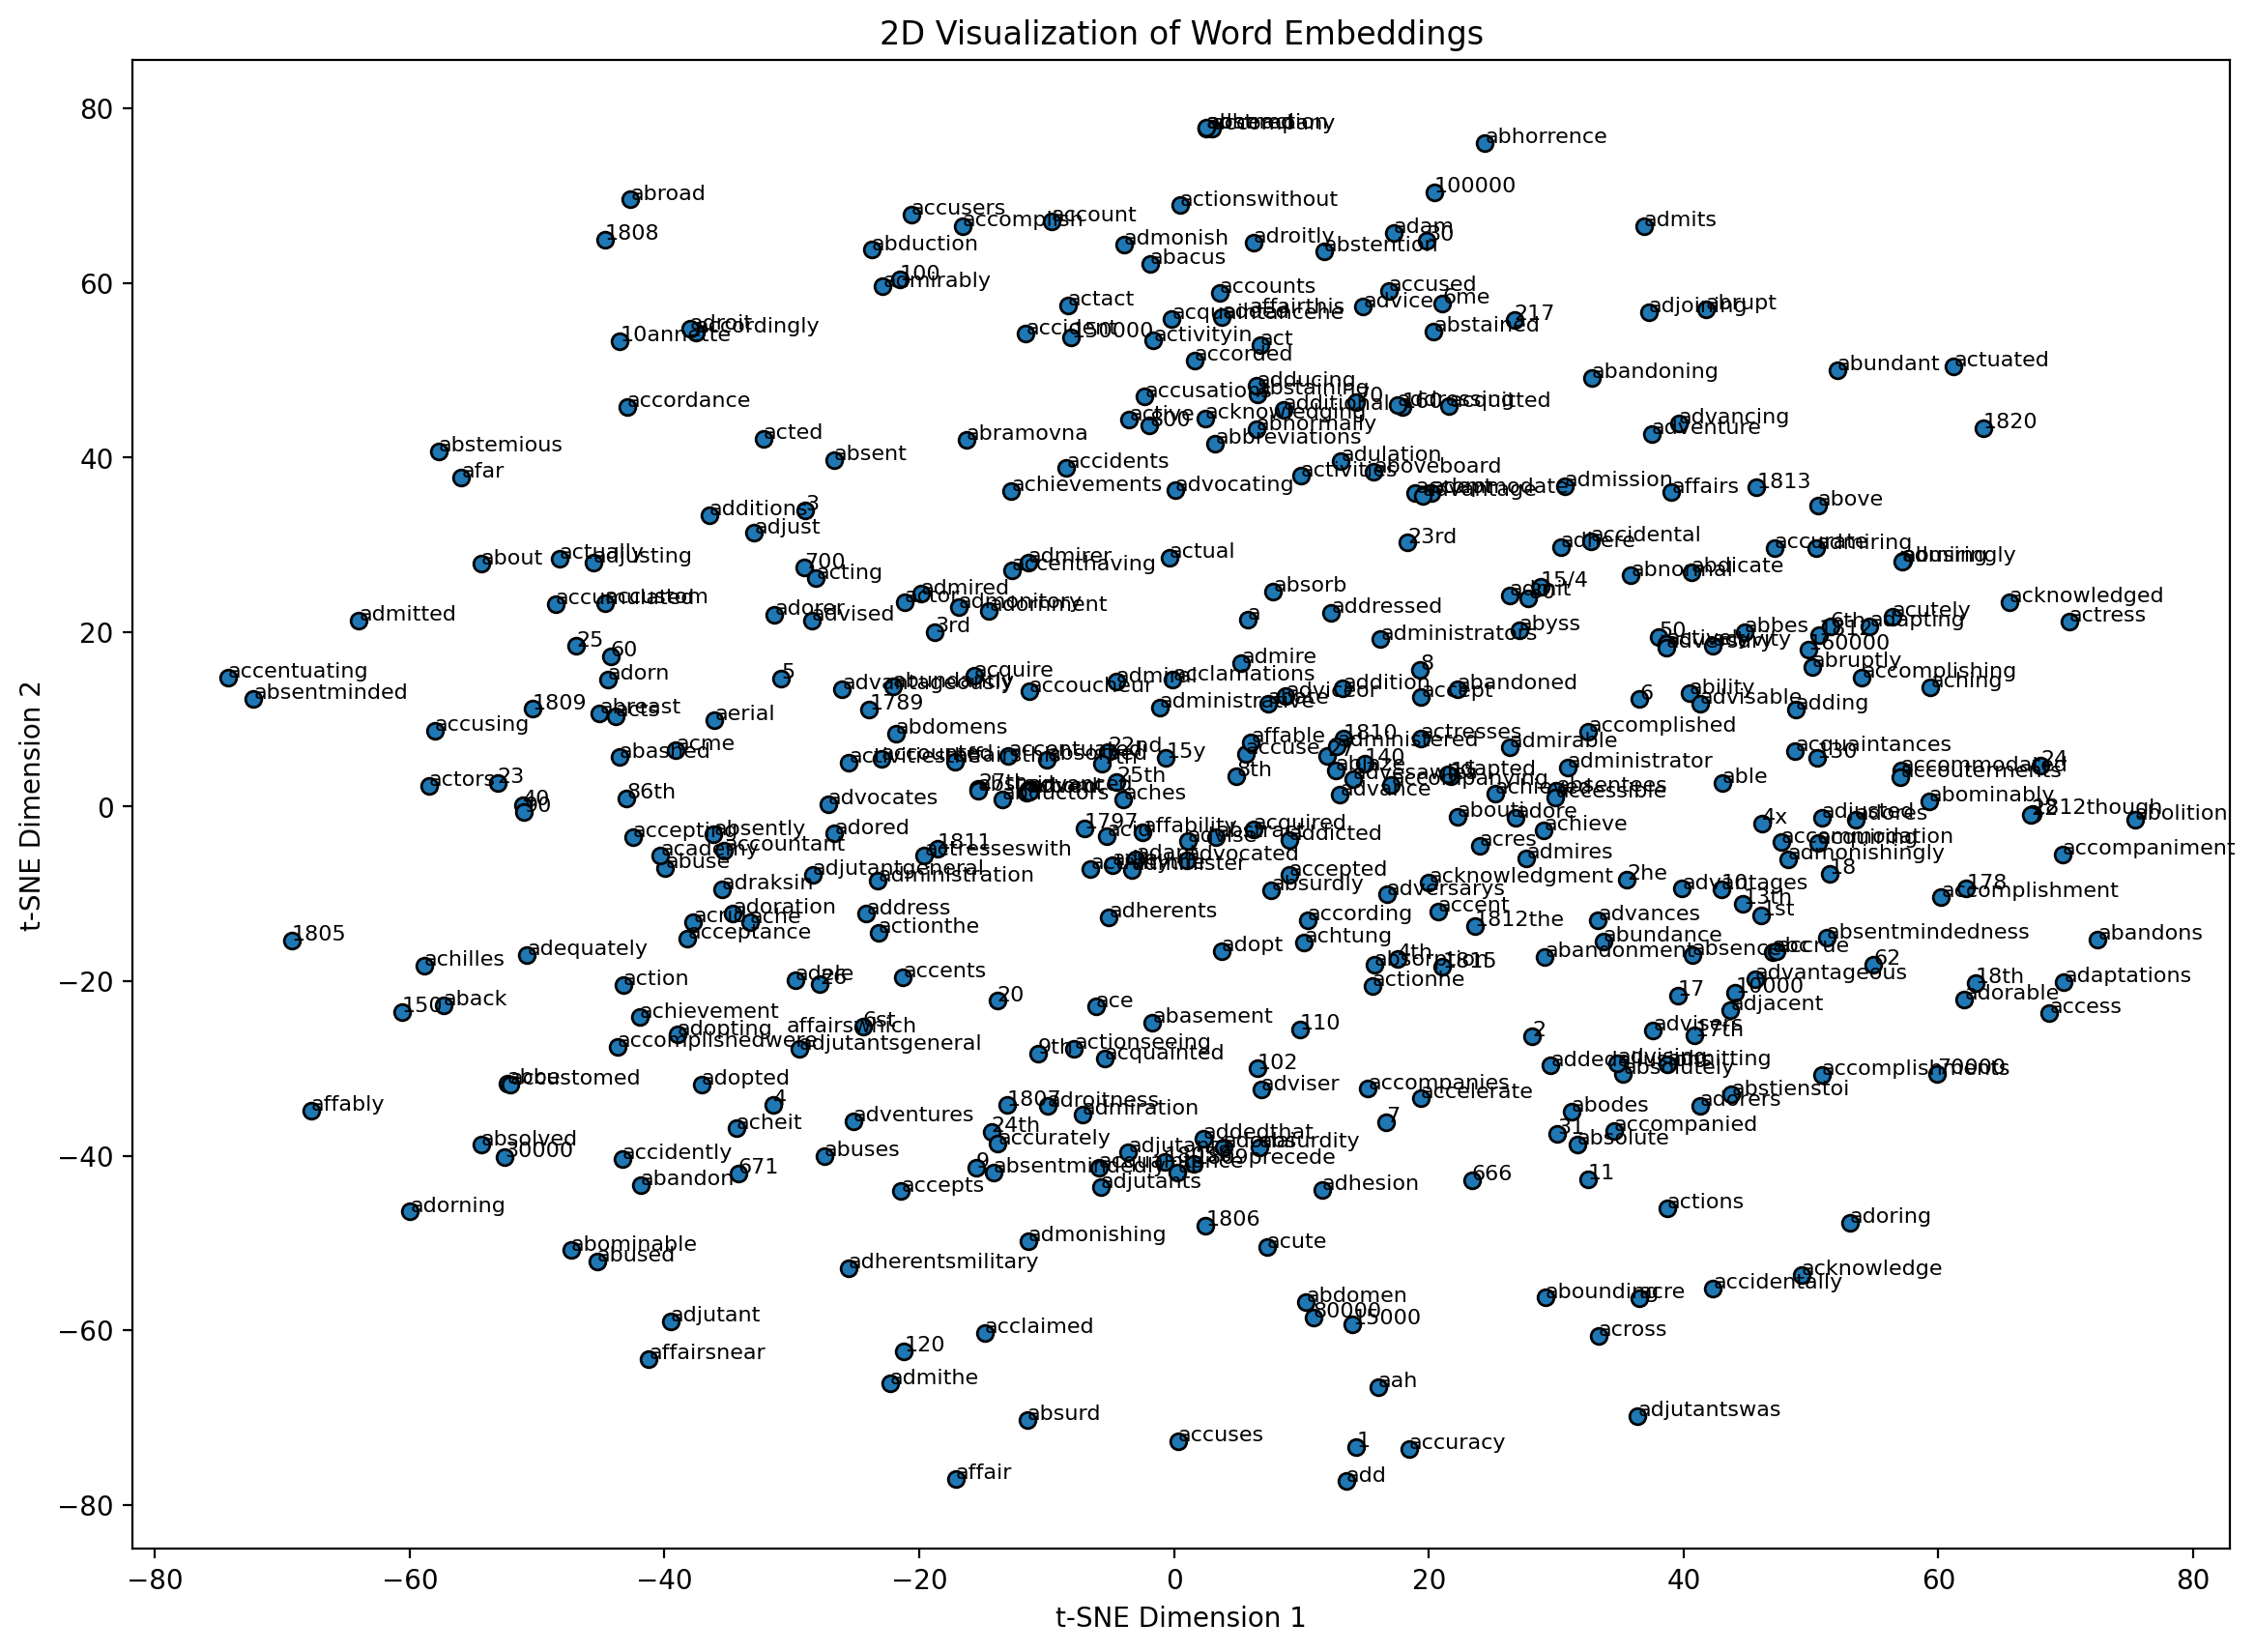

In [45]:
# Plotting the embeddings
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:400, 0], embeddings_2d[:400, 1], marker='o', edgecolor='k')

# Annotate points with words
for i, word in enumerate(word_to_index):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
    if i>400:
        break

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('2D Visualization of Word Embeddings')
plt.show()
